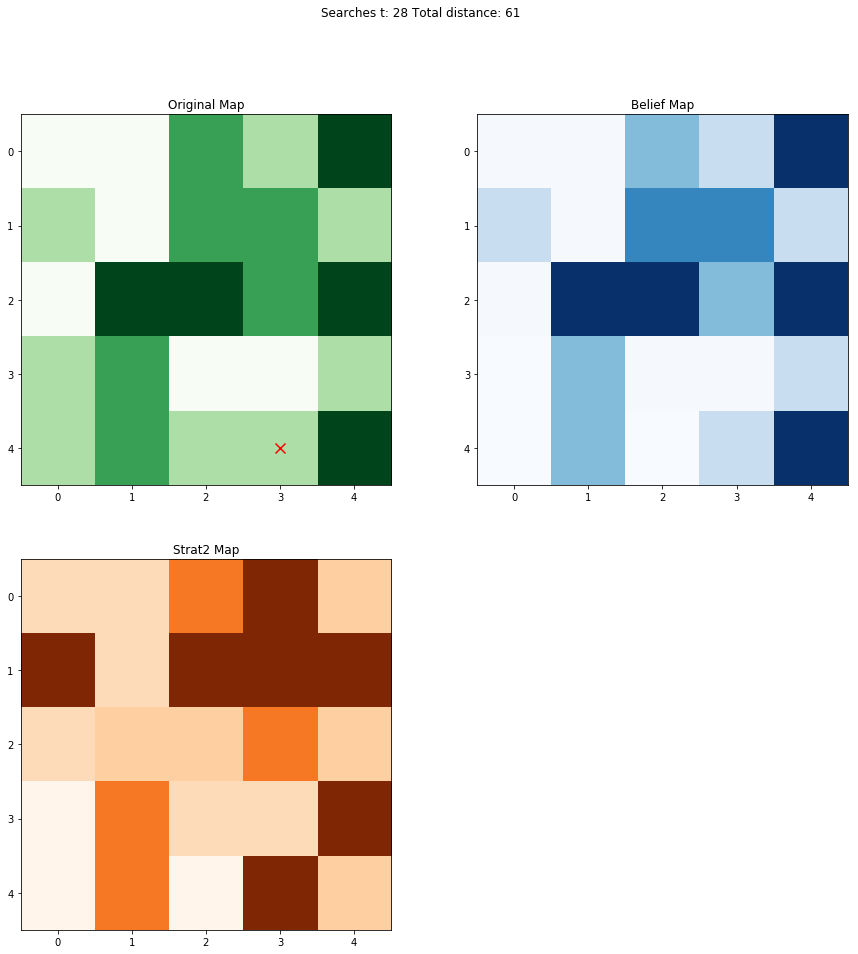

In [57]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib import cm
import random
import matplotlib.gridspec as gridspec
import sys
import copy
import time

dim = 5

flatTerrainRate = 0.1
hillyTerrainRate = 0.3
forestedTerrainRate = 0.7
caveTerrainRate = 0.9

flat = 0 
hilly = 1
forested = 2
cave = 3

# Generates the terrain and values for the map
def generateMap(dim):
        map = np.zeros([dim, dim])
        for i in range(dim):
            for j in range(dim):
                p = np.random.rand()
                if p <= 0.2:
                    # Initialize Flat Terrain
                    map[i][j] = flat
                elif p > 0.2 and p <= 0.5:
                    # Initialize Hilly Terrain
                    map[i][j] = hilly
                elif p > 0.5 and p <= 0.8:
                    # Initialize Forested Terrain
                    map[i][j] = forested
                else:
                    # Initialize Cave Terrain
                    map[i][j] = cave
        return map

# Generates the coordinates of the target marker and agent marker
def generateMarker(dim):
    i = np.random.randint(dim)
    j = np.random.randint(dim)
    return [i, j]

# Generates the initial probability state of the grid for belief and strat2
def generateInitialState(dim):
    initialProb = 1/(dim*dim)
    probState = np.zeros([dim, dim])
    for i in range(dim):
        for j in range(dim):
            probState[i][j] = initialProb
    return probState

# State where agent is at target coordinate and tries to find the target
def targetState(t, map, agent, target):
    foundVal = np.random.rand()
    targeti = agent[0]
    targetj = agent[1]

    # If the randomly generated number is greater than the rate of the target then the target is found
    if map[targeti][targetj] == flat :
        if foundVal > flatTerrainRate :
            return 1
    elif map[targeti][targetj] == hilly :
       if foundVal > hillyTerrainRate :
            return 1
    elif map[targeti][targetj] == forested :
       if foundVal > forestedTerrainRate :
            return 1
    else :
        if foundVal > caveTerrainRate :
            return 1
    
    # if not found we continue with update
    return
        

# Updates our current belief state at time t
def updateBeliefState(dim, beliefState, t, map, agent, target, finalDist, stratTwoState):
    agenti = agent[0]
    agentj = agent[1]
    if (agent[0] == target[0] and agent[1] == target[1]):
        check = targetState(t, map, agent, target)
        # if check successful return 0 and print chart
        if (check == 1) :
            printGrid(map, target, beliefState, stratTwoState, t, finalDist)
            return 0

    beliefState[agenti][agentj]
    if map[agenti][agentj] == flat :
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * flatTerrainRate
    elif map[agenti][agentj] == hilly :
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * hillyTerrainRate
    elif map[agenti][agentj] == forested :
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * forestedTerrainRate
    else :
        beliefState[agenti][agentj] = beliefState[agenti][agentj] * caveTerrainRate
    # Take total of belief state
    newTotal = np.sum(beliefState)

    # Normalize the belief state
    beliefState = beliefState/newTotal

    return beliefState
   

# returns manhattan distance between two coordinates
def manhattanDistance(x1, y1, x2, y2):
        return abs(x1-x2) + abs(y1-y2)

# Searches grid for next position that agent shall search
def searchNext(t, dim, stratTwoState, agent):
    maxVal = 0
    mXCoor = 0
    mYCoor = 0
    dist = 0
    smallestDist = dim * dim
    for searchi in range(dim):
        for searchj in range(dim):
            if stratTwoState[searchi][searchj] > maxVal:
                maxVal = stratTwoState[searchi][searchj]
                mXCoor = searchi
                mYCoor = searchj
                smallestDist = dim * dim
            elif stratTwoState[searchi][searchj] == maxVal:
                manDist = manhattanDistance(searchi, searchj, agent[0], agent[1])
                if manDist < smallestDist:
                    smallestDist = manDist
                    maxVal = stratTwoState[searchi][searchj]
                    mXCoor = searchi
                    mYCoor = searchj
    dist += manhattanDistance(agent[0], agent[1], mXCoor, mYCoor)
    agent[0] = mXCoor
    agent[1] = mYCoor

    return dist

# Updates our current strat2 state at time t based on finding the target in a cell. Using P(Target found in Celli|Observationst).
def updateStrategyTwo(dim, beliefState, stratTwoState, map):
    terrainRate = 0
    for i in range(dim):
        for j in range(dim):
            if map[i][j] == flat :
                terrainRate = flatTerrainRate
            elif map[i][j] == hilly :
                terrainRate = hillyTerrainRate
            elif map[i][j] == forested :
                terrainRate = forestedTerrainRate
            else :
                terrainRate = caveTerrainRate
            stratTwoState[i][j] = (1 - terrainRate) * beliefState[i][j]

    # Take total Of the strat2 matrix
    newstratTwoTotal = np.sum(stratTwoState)

    # Normalize the strat2 matrix to have total probability of 1
    stratTwoState = stratTwoState/newstratTwoTotal        
    return stratTwoState

# Runs the search for the agent
def executeRule2():
    t = 0
    finalDist = 0
    map = generateMap(dim)
    target = generateMarker(dim)
    agent = generateMarker(dim)
    beliefState = generateInitialState(dim) 
    stratTwoState = generateInitialState(dim)
    while True:
        t = t + 1
        beliefState = updateBeliefState(dim, beliefState, t, map, agent, target, finalDist, stratTwoState)
        if isinstance(beliefState,int):
            return
        stratTwoState = updateStrategyTwo(dim, beliefState, stratTwoState, map)
        finalDist +=searchNext(t,dim,stratTwoState,agent)
    return

# Prints the visualization of the originalmap, belief state, strat2 state and displays the amount of searches and total distance 
def printGrid(map, target, beliefState, stratTwoState, t, finalDist):
    totalPerformance = t + finalDist
    grid = gridspec.GridSpec(ncols=2, nrows=2)
    fig = plt.figure(figsize=(15,15))
    ogMap = fig.add_subplot(grid[0, 0])
    beliefMap = fig.add_subplot(grid[0,1])
    stratTwoMap = fig.add_subplot(grid[1,0])
    Image3 = stratTwoMap.imshow(stratTwoState, cmap = cm.get_cmap('Oranges'))
    Image2 = beliefMap.imshow(beliefState, cmap = cm.get_cmap('Blues'))
    Image = ogMap.imshow(map, cmap = cm.get_cmap('Greens', 4))
    stratTwoMap.set_title("Strat2 Map")
    beliefMap.set_title("Belief Map")
    ogMap.set_title("Original Map")
    fig.suptitle('Searches t: {} Total distance: {} Total Performance: {}'.format(t, finalDist, totalPerformance))
    ogMap.scatter(target[1], target[0], s=100, c='red', marker='x')
    return 
executeRule2()

